In [1]:
import pygrib
import numpy as np
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.calc as mpcalc
from metpy.units import units

In [2]:
date = '20200827' # YYYYMMDD
modelRun = '06' # HH
forecastHour = '00' # HH

#from PAndo archive
path = '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/hrrr/sfc/'+date
hrrrFile = '/hrrr.t'+modelRun+'z.wrfsfcf'+forecastHour+'.grib2'

grbs = pygrib.open(path+hrrrFile)


for g in grbs:
  print (g.typeOfLevel, g.level, g.name, g.shortName,g.validDate, g.analDate, g.forecastTime)

# Select the variables you want

# get 200 hPa u wind
u_all_200 = grbs.select(shortName='u',level=250)
# Extract the values
u200 = u_all_200[0].values
# get 200 hPa v wind
v_all_200 = grbs.select(shortName='v',level=250)
# Extract the values
v200 = v_all_200[0].values


# get 10m u wind
u_all = grbs.select(shortName='10u',level=10)
# Extract the values
u10m = u_all[0].values
# get 10m v wind
v_all = grbs.select(shortName='10v',level=10)
# Extract the values
v10m = v_all[0].values

# Get the lat/lon grids
lats_all, lons_all = u_all_200[0].latlons()
print(np.shape(lats_all))
grbs.close()

atmosphere 0 Maximum/Composite radar reflectivity refc 2020-08-27 06:00:00 2020-08-27 06:00:00 0
cloudTop 0 unknown unknown 2020-08-27 06:00:00 2020-08-27 06:00:00 0
atmosphere 0 Vertically-integrated liquid veril 2020-08-27 06:00:00 2020-08-27 06:00:00 0
surface 0 Visibility vis 2020-08-27 06:00:00 2020-08-27 06:00:00 0
heightAboveGround 1000 Derived radar reflectivity refd 2020-08-27 06:00:00 2020-08-27 06:00:00 0
heightAboveGround 4000 Derived radar reflectivity refd 2020-08-27 06:00:00 2020-08-27 06:00:00 0
isothermal 263 Derived radar reflectivity refd 2020-08-27 06:00:00 2020-08-27 06:00:00 0
surface 0 Wind speed (gust) gust 2020-08-27 06:00:00 2020-08-27 06:00:00 0
isobaricInhPa 250 U component of wind u 2020-08-27 06:00:00 2020-08-27 06:00:00 0
isobaricInhPa 250 V component of wind v 2020-08-27 06:00:00 2020-08-27 06:00:00 0
isobaricInhPa 300 U component of wind u 2020-08-27 06:00:00 2020-08-27 06:00:00 0
isobaricInhPa 300 V component of wind v 2020-08-27 06:00:00 2020-08-27 06

surface 0 Downward short-wave radiation flux dswrf 2020-08-27 06:00:00 2020-08-27 06:00:00 0
surface 0 Downward long-wave radiation flux dlwrf 2020-08-27 06:00:00 2020-08-27 06:00:00 0
surface 0 Upward short-wave radiation flux uswrf 2020-08-27 06:00:00 2020-08-27 06:00:00 0
surface 0 Upward long-wave radiation flux ulwrf 2020-08-27 06:00:00 2020-08-27 06:00:00 0
surface 0 Visible Beam Downward Solar Flux vbdsf 2020-08-27 06:00:00 2020-08-27 06:00:00 0
surface 0 Visible Diffuse Downward Solar Flux vddsf 2020-08-27 06:00:00 2020-08-27 06:00:00 0
nominalTop 0 Upward short-wave radiation flux uswrf 2020-08-27 06:00:00 2020-08-27 06:00:00 0
heightAboveGroundLayer 3000 Storm relative helicity hlcy 2020-08-27 06:00:00 2020-08-27 06:00:00 0
heightAboveGroundLayer 1000 Storm relative helicity hlcy 2020-08-27 06:00:00 2020-08-27 06:00:00 0
heightAboveGroundLayer 0 U-component storm motion ustm 2020-08-27 06:00:00 2020-08-27 06:00:00 0
heightAboveGroundLayer 0 V-component storm motion vstm 2020-

In [3]:
#make the data more manageable in this case for a Laura centric sector
#lower left corner lat/lon
ult =50
uln = 880
#upper right corner lat/lon
rlt =350
rln = 1200

#truncate the arrays
u20 = u200[ult:rlt,uln:rln]
v20 = v200[ult:rlt,uln:rln]
#truncate the arrays
u10 = u10m[ult:rlt,uln:rln]
v10 = v10m[ult:rlt,uln:rln]

lats = lats_all[ult:rlt,uln:rln]
lons = lons_all[ult:rlt,uln:rln]
print(lats[0,0],lons[0,0])

25.67683880055014 -98.06039203620756


In [4]:
# use metpy functions to do the 'heavy lifting'
#https://unidata.github.io/MetPy/
#find the increments in each direction on the grid
dx, dy = mpcalc.lat_lon_grid_deltas(lons,lats)
print(np.shape(dx),np.shape(dy))
#metpy needs units declared for calculations
# calculate speed of wind
u10 = u10 * units.meter / units.second
v10 = v10 * units.meter / units.second
sp10 = mpcalc.wind_speed(u10, v10)
u20 = u20 * units.meter / units.second
v20 = v20 * units.meter / units.second
sp20 = mpcalc.wind_speed(u20, v20)
print(np.max(sp10.m),np.max(sp20.m))

(300, 319) (299, 320)
40.43086 36.52448


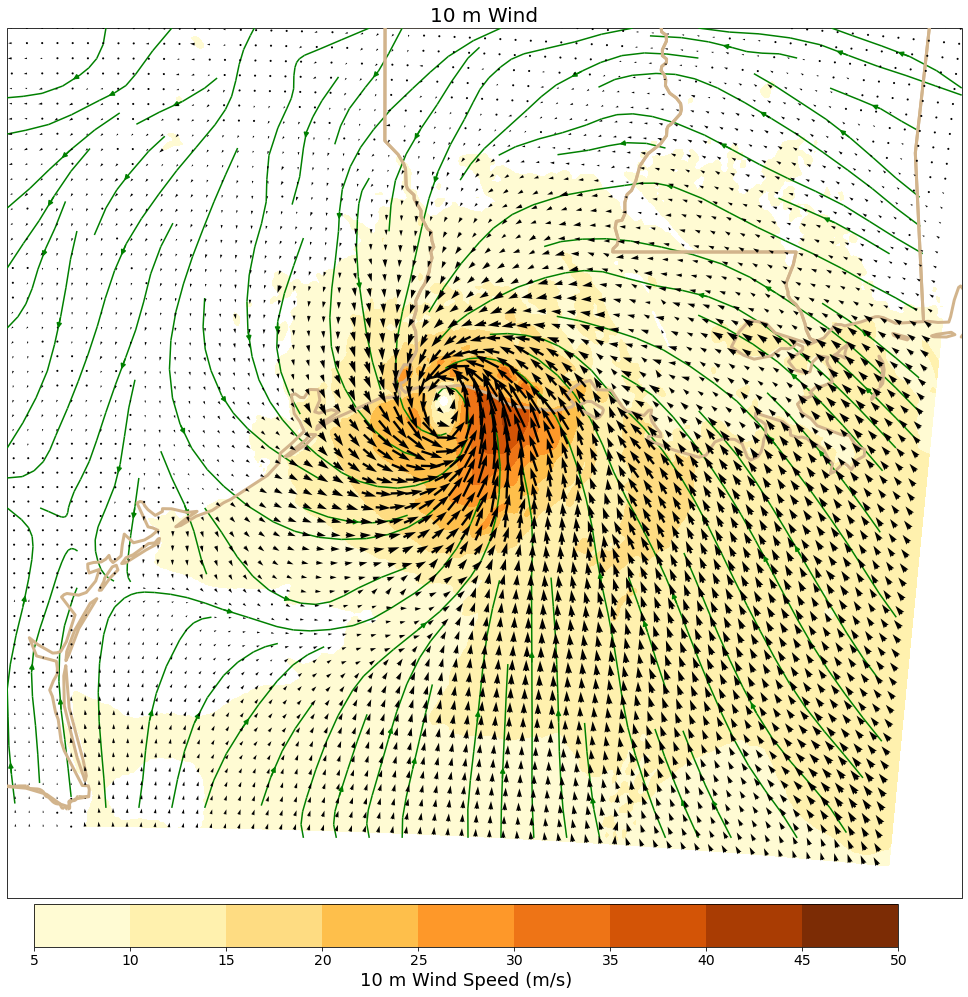

In [5]:
# color maps
rcol = mcm.get_cmap('YlOrBr')
bcol = mcm.get_cmap('GnBu_r')

#plot10 m winds
fig = plt.figure(figsize=(20,16))
states = cartopy.feature.NaturalEarthFeature(
            category='cultural', scale='50m', facecolor='none',
            name='admin_1_states_provinces_shp')
ax1 = plt.axes(projection=ccrs.Mercator())

ax1.set_extent([int(lons.min()),int(lons.max())-1,int(lats.min()),int(lats.max())])

clevs = np.arange(5,55,5)

cs = ax1.contourf(lons,lats,sp10.m,levels=clevs,cmap=rcol,transform=ccrs.PlateCarree(),zorder=10)
cb_ax = fig.add_axes([.2,.06,.6,.4],visible=None)
cbar = plt.colorbar(cs,ax=cb_ax,orientation='horizontal')
cbar.set_label('10 m Wind Speed (m/s)',size=18)
cbar.ax.tick_params(labelsize=14)

ax1.streamplot(lons,lats, u10.m,v10.m,arrowsize=1,color='green',zorder=90,transform=ccrs.PlateCarree())
skip=(slice(None,None,5),slice(None,None,5))
ax1.quiver(lons[skip],lats[skip],u10.m[skip],v10.m[skip],pivot='tail',scale=75, scale_units='inches',color='black',zorder=99,transform=ccrs.PlateCarree())
ax1.add_feature(states,zorder=98,edgecolor='tan',linewidth=3)
ax1.add_feature(cartopy.feature.BORDERS,zorder=99,edgecolor='tan',linewidth=3)
ax1.set_title('10 m Wind',fontsize=20)
plot_file = '../figs/hrrr_10m_winds_laura_' + date + modelRun + forecastHour + '.png'
plt.savefig(plot_file)
plt.show()

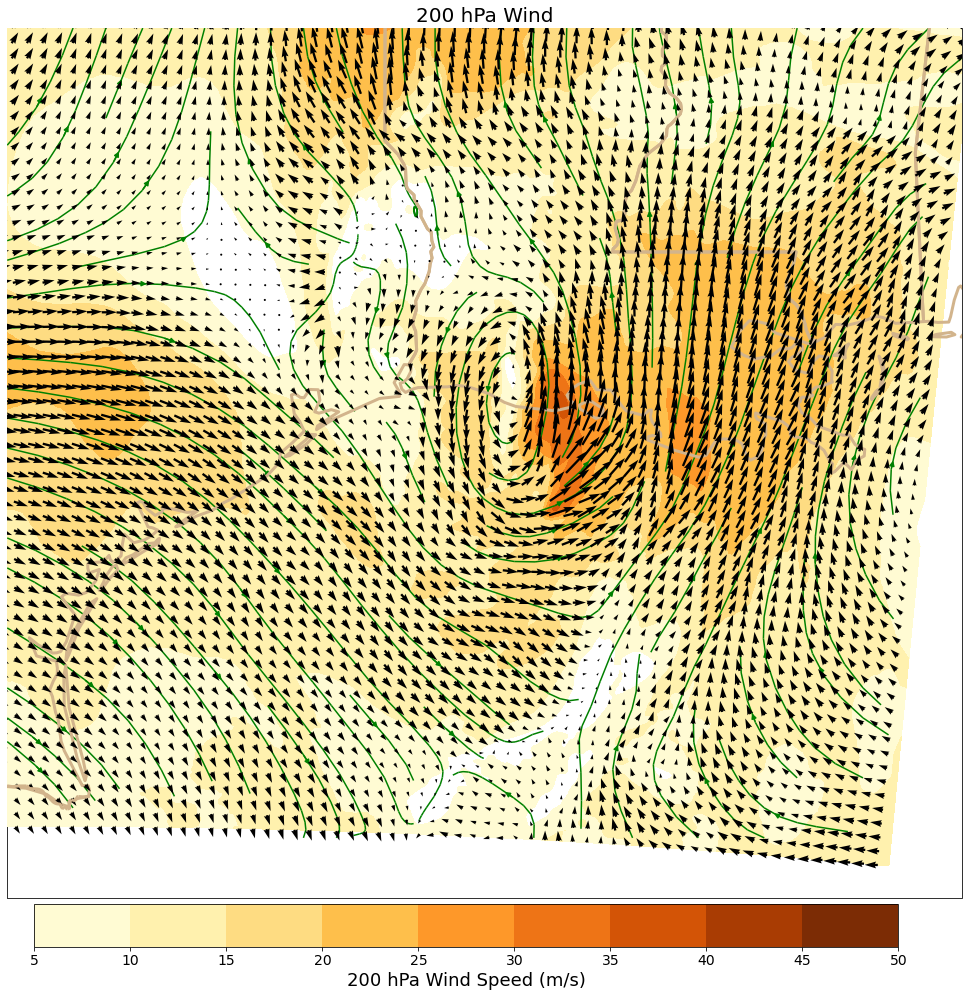

In [6]:
#plot 200 hPa winds
fig = plt.figure(figsize=(20,16))
ax2 = plt.axes(projection=ccrs.Mercator())

ax2.set_extent([int(lons.min()),int(lons.max())-1,int(lats.min()),int(lats.max())])
clevs = np.arange(5,55,5)
cs = ax2.contourf(lons,lats,sp20.m,levels=clevs,cmap=rcol,transform=ccrs.PlateCarree(),zorder=10)
cb_ax = fig.add_axes([.2,.06,.6,.4],visible=None)
cbar = plt.colorbar(cs,ax=cb_ax,orientation='horizontal')
cbar.set_label('200 hPa Wind Speed (m/s)',size=18)
cbar.ax.tick_params(labelsize=14)

ax2.streamplot(lons,lats, u20.m,v20.m,arrowsize=1,color='green',zorder=90,transform=ccrs.PlateCarree())
skip=(slice(None,None,5),slice(None,None,5))
ax2.quiver(lons[skip],lats[skip],u20.m[skip],v20.m[skip],pivot='tail',scale=75, scale_units='inches',color='black',zorder=99,transform=ccrs.PlateCarree())

ax2.add_feature(states,zorder=98,edgecolor='tan',linewidth=3)
ax2.add_feature(cartopy.feature.BORDERS,zorder=99,edgecolor='tan',linewidth=3)
ax2.set_title('200 hPa Wind',fontsize=20)

plot_file = '../figs/hrrr_200hPa_winds_laura_' + date + modelRun + forecastHour + '.png'
plt.savefig(plot_file)
plt.show()

In [7]:
#compute 10m wind divergence
#smooth the fields a bit
u10s = mpcalc.smooth_gaussian(u10,3)
v10s = mpcalc.smooth_gaussian(v10,3)

div10 = mpcalc.divergence(u10s,v10s,dx,dy,dim_order='yx')
div10 = div10 *1.E4
print('min 10m divergence %.1e' % np.min(div10.m))
print('max 10m divergence %.1e' % np.max(div10.m))


#compute 200 hPa wind divergence

u20s = mpcalc.smooth_gaussian(u20,3)
v20s = mpcalc.smooth_gaussian(v20,3)
div20 = mpcalc.divergence(u20s,v20s,dx,dy,dim_order='yx')
div20 = div20 *1.E4
print('min 20o hPa divergence %.1e' % np.min(div20.m))
print('max 200 hPA divergence %.1e' % np.max(div20.m))


div_int = 2
dlev_n=np.arange(-div_int*8,0,div_int)
dlev_p=np.arange(div_int,div_int*8,div_int)


min 10m divergence -2.3e+01
max 10m divergence 1.6e+01
min 20o hPa divergence -1.5e+01
max 200 hPA divergence 3.1e+01


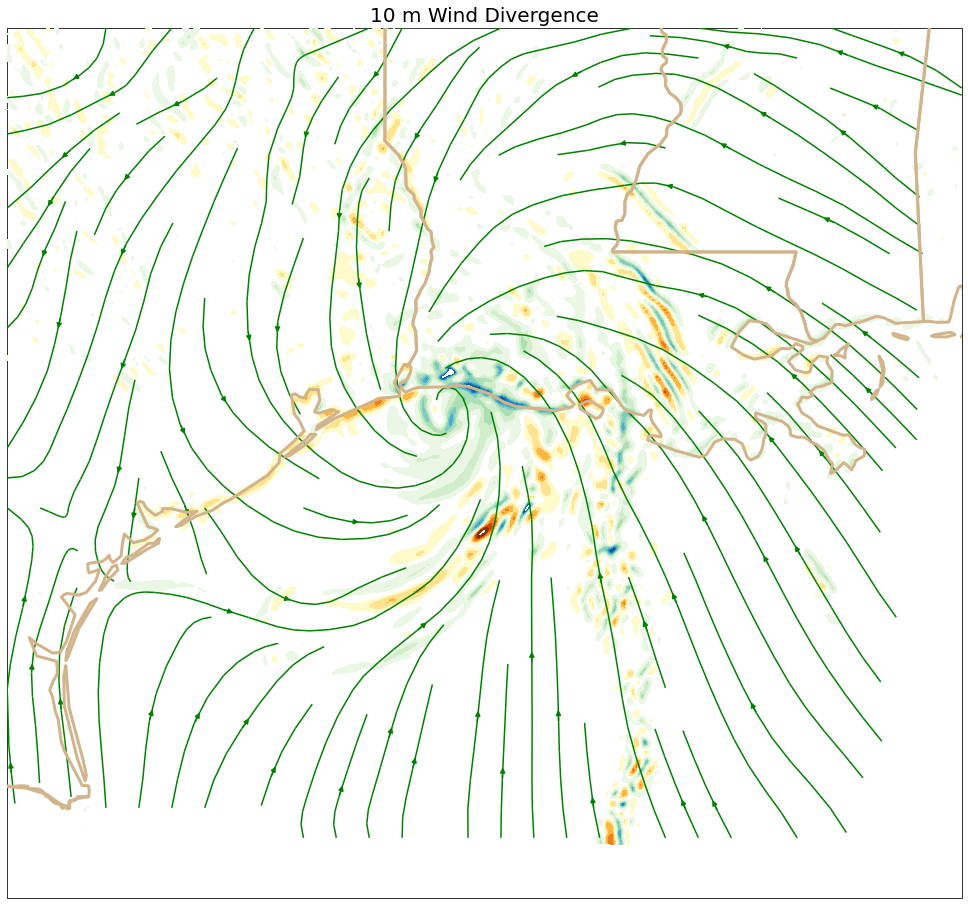

In [8]:
# Plot 10 m wind divergence
# color maps
rcol = mcm.get_cmap('YlOrBr')
bcol = mcm.get_cmap('GnBu_r')

#plot 10 m wind divergence
fig = plt.figure(figsize=(20,16))
ax1 = plt.axes(projection=ccrs.Mercator())

ax1.set_extent([int(lons.min()),int(lons.max())-1,int(lats.min()),int(lats.max())])

cs = ax1.contourf(lons,lats,div10.m,levels=dlev_p,cmap=rcol,transform=ccrs.PlateCarree(),zorder=10)
cs = ax1.contourf(lons,lats,div10.m,levels=dlev_n,cmap=bcol,transform=ccrs.PlateCarree(),zorder=10)


ax1.streamplot(lons,lats, u10.m,v10.m,arrowsize=1,color='green',zorder=90,transform=ccrs.PlateCarree())
skip=(slice(None,None,5),slice(None,None,5))
#ax1.quiver(lons[skip],lats[skip],u10.m[skip],v10.m[skip],pivot='tail',scale=75, scale_units='inches',color='black',zorder=99,transform=ccrs.PlateCarree())
ax1.add_feature(states,zorder=98,edgecolor='tan',linewidth=3)
ax1.add_feature(cartopy.feature.BORDERS,zorder=99,edgecolor='tan',linewidth=3)
ax1.set_title('10 m Wind Divergence',fontsize=20)
plot_file = '../figs/hrrr_10m_wind_div_laura_' + date + modelRun + forecastHour + '.png'
plt.savefig(plot_file)
plt.show()


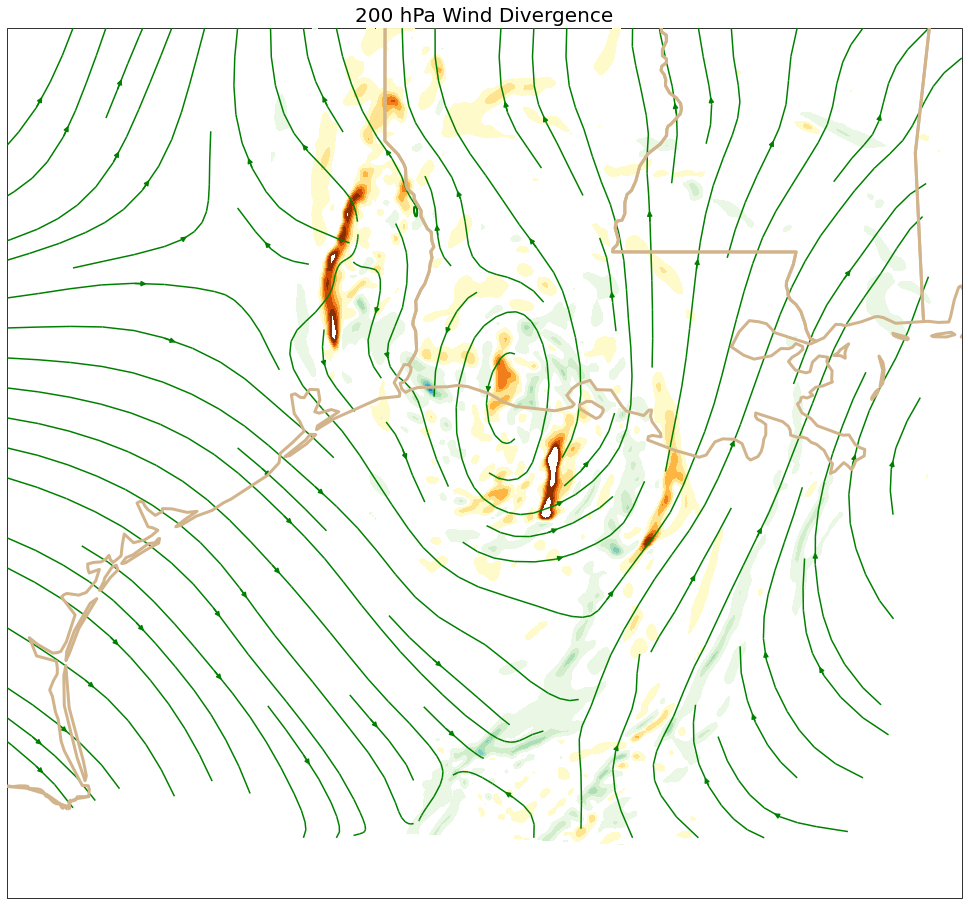

In [9]:
# Plot 200 hPa wind divergence

fig = plt.figure(figsize=(20,16))
ax1 = plt.axes(projection=ccrs.Mercator())

ax1.set_extent([int(lons.min()),int(lons.max())-1,int(lats.min()),int(lats.max())])

cs = ax1.contourf(lons,lats,div20.m,levels=dlev_p,cmap=rcol,transform=ccrs.PlateCarree(),zorder=10)
cs = ax1.contourf(lons,lats,div20.m,levels=dlev_n,cmap=bcol,transform=ccrs.PlateCarree(),zorder=10)


ax1.streamplot(lons,lats, u20.m,v20.m,arrowsize=1,color='green',zorder=90,transform=ccrs.PlateCarree())
skip=(slice(None,None,5),slice(None,None,5))
#ax1.quiver(lons[skip],lats[skip],u20.m[skip],v20.m[skip],pivot='tail',scale=75, scale_units='inches',color='black',zorder=99,transform=ccrs.PlateCarree())
ax1.add_feature(states,zorder=98,edgecolor='tan',linewidth=3)
ax1.add_feature(cartopy.feature.BORDERS,zorder=99,edgecolor='tan',linewidth=3)
ax1.set_title('200 hPa Wind Divergence',fontsize=20)
plot_file = '../figs/hrrr_200hPa_wind_div_laura_' + date + modelRun + forecastHour + '.png'
plt.savefig(plot_file)
plt.show()


In [10]:
#compute vorticity using smoothed winds
vor10 = mpcalc.vorticity(u10s,v10s,dx,dy,dim_order='yx')
vor10 = vor10 *1.E4
print('min 10 m vorticity  %.1e' % np.min(vor10.m))
print('max 10 m vorticity %.1e' % np.max(vor10.m))


vor20 = mpcalc.vorticity(u20s,v20s,dx,dy,dim_order='yx')
vor20 = vor20 *1.E4
print('min 200 hPa vorticity %.1e' % np.min(div20.m))
print('max 200 hPA vorticity %.1e' % np.max(div20.m))
vor_int = 3
vlev_n=np.arange(-vor_int*8,0,vor_int)
vlev_p=np.arange(vor_int,vor_int*8,vor_int)


min 10 m vorticity  -1.8e+01
max 10 m vorticity 3.2e+01
min 200 hPa vorticity -1.5e+01
max 200 hPA vorticity 3.1e+01


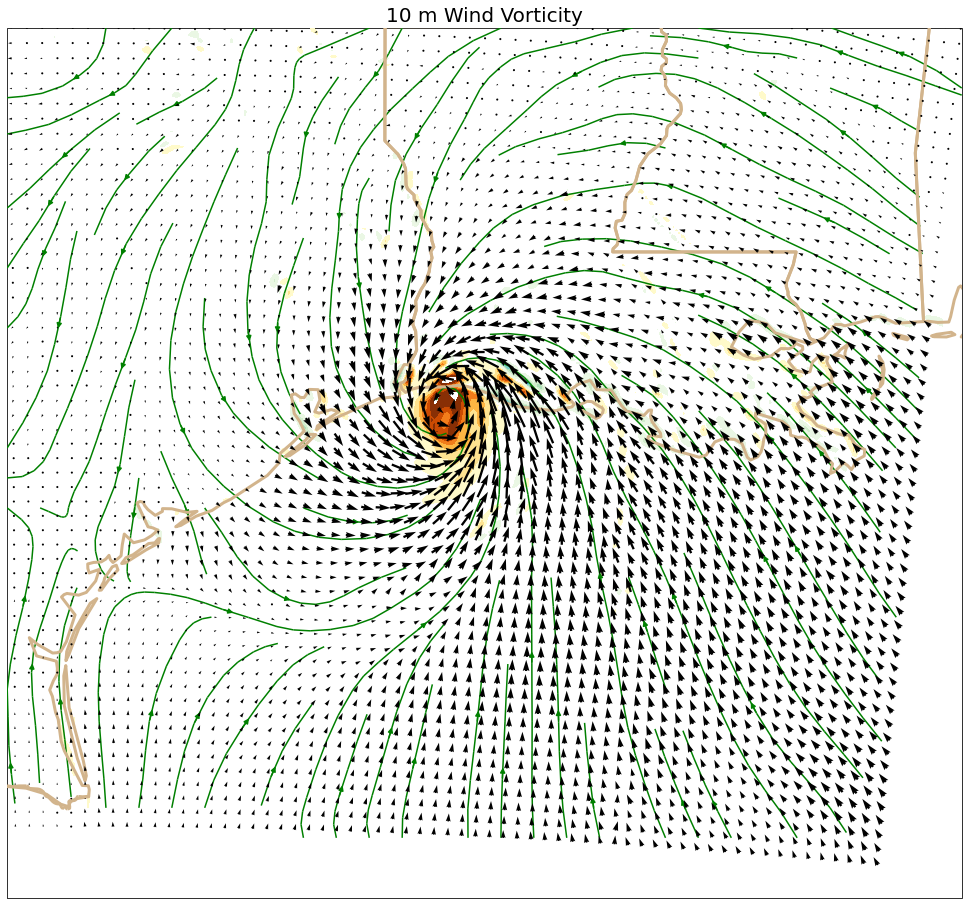

In [11]:
#plot 10 m wind vorticity
fig = plt.figure(figsize=(20,16))
ax1 = plt.axes(projection=ccrs.Mercator())

ax1.set_extent([int(lons.min()),int(lons.max())-1,int(lats.min()),int(lats.max())])

cs = ax1.contourf(lons,lats,vor10.m,levels=vlev_p,cmap=rcol,transform=ccrs.PlateCarree(),zorder=10)
cs = ax1.contourf(lons,lats,vor10.m,levels=vlev_n,cmap=bcol,transform=ccrs.PlateCarree(),zorder=10)


ax1.streamplot(lons,lats, u10.m,v10.m,arrowsize=1,color='green',zorder=90,transform=ccrs.PlateCarree())
skip=(slice(None,None,5),slice(None,None,5))
ax1.quiver(lons[skip],lats[skip],u10.m[skip],v10.m[skip],pivot='tail',scale=75, scale_units='inches',color='black',zorder=99,transform=ccrs.PlateCarree())
ax1.add_feature(states,zorder=98,edgecolor='tan',linewidth=3)
ax1.add_feature(cartopy.feature.BORDERS,zorder=99,edgecolor='tan',linewidth=3)
ax1.set_title('10 m Wind Vorticity',fontsize=20)
plot_file = '../figs/hrrr_10m_wind_vor_laura_' + date + modelRun + forecastHour + '.png'
plt.savefig(plot_file)
plt.show()

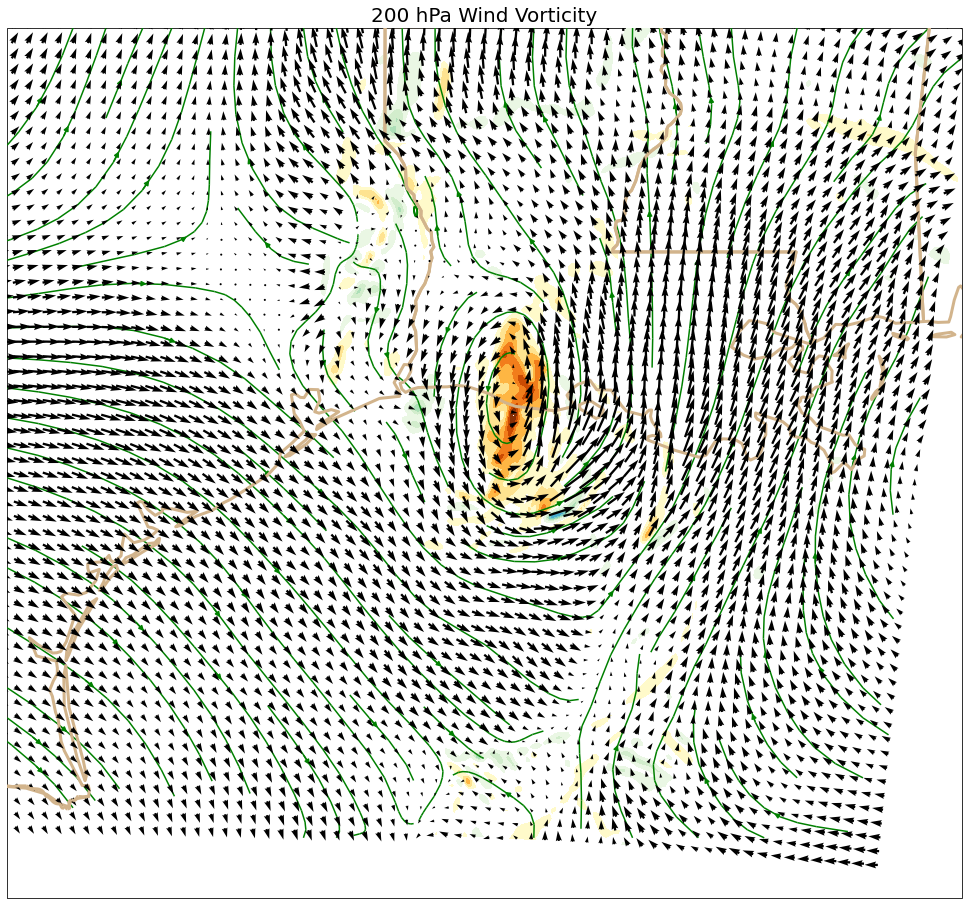

In [12]:
#plot 200 hPa wind vorticity
fig = plt.figure(figsize=(20,16))
ax1 = plt.axes(projection=ccrs.Mercator())

ax1.set_extent([int(lons.min()),int(lons.max())-1,int(lats.min()),int(lats.max())])

cs = ax1.contourf(lons,lats,vor20.m,levels=vlev_p,cmap=rcol,transform=ccrs.PlateCarree(),zorder=10)
cs = ax1.contourf(lons,lats,vor20.m,levels=vlev_n,cmap=bcol,transform=ccrs.PlateCarree(),zorder=10)


ax1.streamplot(lons,lats, u20.m,v20.m,arrowsize=1,color='green',zorder=90,transform=ccrs.PlateCarree())
skip=(slice(None,None,5),slice(None,None,5))
ax1.quiver(lons[skip],lats[skip],u20.m[skip],v20.m[skip],pivot='tail',scale=75, scale_units='inches',color='black',zorder=99,transform=ccrs.PlateCarree())
ax1.add_feature(states,zorder=98,edgecolor='tan',linewidth=3)
ax1.add_feature(cartopy.feature.BORDERS,zorder=99,edgecolor='tan',linewidth=3)
ax1.set_title('200 hPa Wind Vorticity',fontsize=20)
plot_file = '../figs/hrrr_200hPa_wind_vor_laura_' + date + modelRun + forecastHour + '.png'
plt.savefig(plot_file)
plt.show()